Simulation of AD model from:

Dynamical Adaptation in Photoreceptors
Damon A. Clark,Raphael Benichou,Markus Meister,Rava Azeredo da Silveira 
Published: November 14, 2013https://doi.org/10.1371/journal.pcbi.1003289
parameters are from here

Also, feedback from Drinnenberg's paper

s - stimulation   r - response



In [1]:
import numpy as np
from random import gauss
from math import sqrt
import matplotlib as mpl
mpl.use('nbagg')
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
def fac(n):
    value =1 
    for i in range(1,int(n+1)):
        value = value*i
    return(int(value))

def bf(t,tau,n):
    nf = fac(n)
    return(np.exp(-t/tau)*t**int(n)/nf/tau**(n+1))

def Ky(t,tau_y,n_y):
    return(bf(t,tau_y,n_y))

def Kz(t,gamma,tau_y,n_y,tau_z,n_z):
    A = bf(t,tau_y,n_y)
    B = bf(t,tau_z,n_z)
    return(gamma*A + (1-gamma)*B)

In [3]:
def K1(t):
    return(np.sin(np.pi*t/mu)*1./sqrt(2*np.pi*sigma)*np.exp(-0.5*((t-mu)/sigma)**2))

def K2(t):
    return(np.exp(-t/tau2)/tau2 - np.exp(-t/c2/tau2)/c2/tau2)

def K3(t):
    return(np.exp(-t/tau3)/tau3)

In [4]:
def rescale(x,xmax,xmin):
    rx = np.zeros(len(x))
    xminval = np.min(x)
    xmaxval = np.max(x)
    for i in range(len(x)):
        rx[i] = (x[i]-xminval)/(xmaxval-xminval)*(xmax-xmin)+xmin
    return rx
# using numpy's histogram2d to calculate the mutual information between two sequences
def mi_quick(a,b,d,bn=25):
    if d>0: xy,_,_ = np.histogram2d(a[d:],b[:-d],bn)
    elif d<0: xy,_,_ = np.histogram2d(a[:d],b[-d:],bn)
    else: xy,_,_ = np.histogram2d(a,b,bn)
    xy /= np.sum(xy)
    px = [np.array([max(x,1e-100) for x in np.sum(xy,axis=0)])]
    py = np.transpose([[max(x,1e-100) for x in np.sum(xy,axis=1)]])
    nxy = (xy/px)/py
    nxy[nxy==0] = 1e-100
    return np.sum(xy*np.log2(nxy))

In [5]:
n_y = 2
n_z = 3
tau_y = 50
tau_z = 60
gamma = 0.5

0.9999999993333545 0.9999992439288232


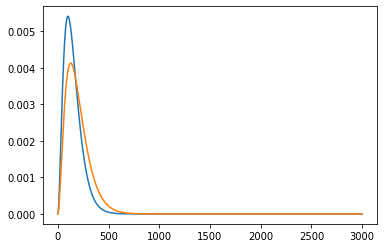

In [6]:
# shapes of the kernel
klen = 3001 # kernel length
tt = np.arange(klen)

# generate the time series for the kernels
# will be used for computation of convolution with signal

kyts = Ky(tt,tau_y,n_y)
kzts = Kz(tt,gamma,tau_y,n_y,tau_z,n_z)
plt.plot(kyts)
plt.plot(kzts)
print(np.sum(kyts),np.sum(kzts))

(0, 2000)

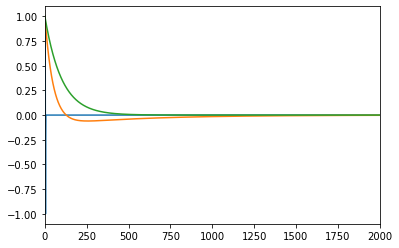

In [7]:
mu = 3
sigma = 1
tau2 = 50
tau3 = 100
c2 = 10

k1ts = K1(tt)
k2ts = K2(tt)
k3ts = K3(tt)
plt.plot(k1ts/np.max(k1ts))
plt.plot(k2ts/np.max(k2ts))
plt.plot(k3ts/np.max(k3ts))
plt.xlim([0,2000])

In [8]:
step = 8             # totoal number of steps in change of contrast
n = 1800             # number of points within one step
lead = 6000           # lead time before stimulation start
npts = step*n + lead # total number of steps in the simulation
dt = 1               # time stepsize in milli-second
t = np.zeros(npts)   # time in second
for i in range(npts):
    t[i] = i*dt

ii = np.zeros(npts)
contrast =[1,-2,3,-4,5,-6,7,-8,9,-10,11]
mean_intensity = 5

for i in range(lead):
    ii[i] = mean_intensity +contrast[0]/4

for j in range(step):
    for i in range(n):
        index = lead +j*n+i
        ii[index] = mean_intensity + contrast[j+1]/4
ss = ii
s = ss[klen-1:]      # becaues of convolution in numpy, we need to remove 
                     # the first klen points from the signal when compared with convoluted signal

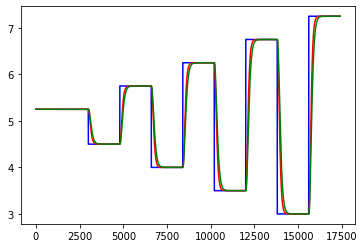

In [9]:
# s is the signal with the first klen points removed
# but we need to use original signal ss for convolution

y = np.convolve(ss,kyts,'valid')
z = np.convolve(ss,kzts,'valid')

plt.plot(s,'b')
plt.plot(y,'r')
plt.plot(z,'g')
#plt.xlim([0,10000])

In [10]:
# Main loop starts here after ss, z and y are generated
# ss, z and y are all evaluated at 1msec 
# dt =1 means we are integrating with dt = 1

dt = 1
nstep = len(y)
alpha = 1
beta = 0.2
tau_r = 30

r = np.zeros(nstep)
for i in range(1,nstep-1):
    dr = (alpha*y[i] - (1 + beta*z[i])*r[i])*dt/tau_r
    r[i+1] = r[i] + dr

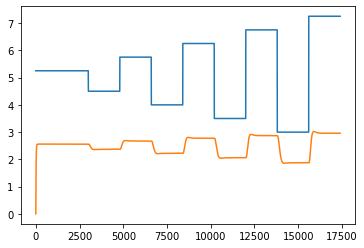

In [11]:
r1=r
plt.plot(s)
plt.plot(r1)

In [12]:
def Kh(t,tau_h):
    return(np.exp(-t/tau_h)*t/tau_h/tau_h)

In [13]:
tau_h = 317
alpha_h = 0.792
khts = Kh(tt,tau_h)

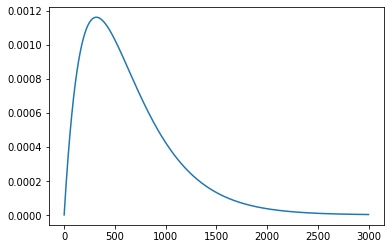

In [14]:
plt.plot(khts)

# with feedback phi = 1.0

In [15]:
# with feedback from h, phi = 1.0
# solving eqn from Drinenberg
tau_h = 317
alpha_h = 0.792

dt = 1
nstep = len(y)
alpha = 1
beta = 0.2
tau_r = 30

phi = 1.0
tau_yh = tau_h
alpha_yh = alpha_h
r = np.zeros(nstep)
h = np.zeros(nstep)
yh = np.zeros(nstep)

for i in range(1,nstep):
    dr =  (alpha*y[i-1] - (1 + beta*z[i-1])*(r[i-1] + phi*h[i-1]))*dt/tau_r
    
    dh =  (alpha_h*yh[i-1] - h[i-1])*dt/tau_h
    dyh = (alpha_yh*r[i-1] - yh[i-1])*dt/tau_yh
    r[i] = r[i-1] + dr
    h[i] = h[i-1] + dh
    yh[i] = yh[i-1] + dyh

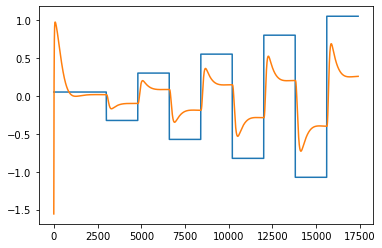

In [16]:
r1 = r.copy()
plt.plot((s-np.mean(s))/2)
plt.plot(r1-np.mean(r1))
#plt.xlim([0,80000])

# no feedback phi = 0.0

In [17]:
# with feedback from h, phi = 0.0
tau_h = 317
alpha_h = 0.792
dt = 1
nstep = len(y)
alpha = 1
beta = 0.2
tau_r = 30

phi = 0.0
tau_yh = tau_h
alpha_yh = alpha_h
r = np.zeros(nstep)
h = np.zeros(nstep)
yh = np.zeros(nstep)
for i in range(1,nstep):
    dr = (alpha*y[i-1] - (1 + beta*z[i-1])*(r[i-1] + phi*h[i-1]))*dt/tau_r
    dh = (alpha_h*yh[i-1] - h[i-1])*dt/tau_h
    dyh = (alpha_yh*r[i-1] - yh[i-1])*dt/tau_yh
    r[i] = r[i-1] + dr
    h[i] = h[i-1] + dh
    yh[i] = yh[i-1] + dyh

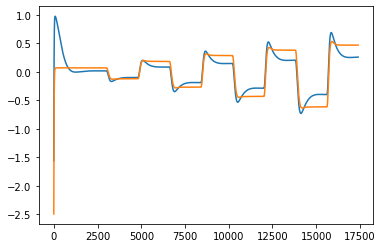

In [18]:
r2 = r.copy()
plt.plot(r1-np.mean(r1))
plt.plot(r2-np.mean(r2))

In [19]:
def K1(t):
    return(np.sin(np.pi*t/mu)*1./sqrt(2*np.pi*sigma)*np.exp(-0.5*((t-mu)/sigma)**2))

def K2(t):
    c2=100*tau2
    return(np.exp(-t/tau2)/tau2 - np.exp(-t/c2/tau2)/c2/tau2)

def K3(t):
    return(np.exp(-t/tau3)/tau3)

(0, 500)

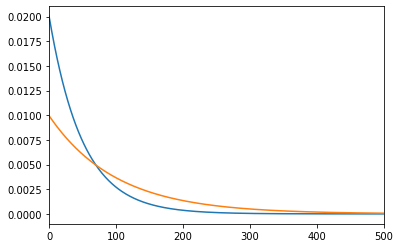

In [20]:
#plt.plot(k1ts)
k2ts=K2(tt)
k2ts=k2ts/np.sum(k2ts)
k3ts=K3(tt)
k3ts=k3ts/np.sum(k3ts)
plt.plot(k2ts)
plt.plot(k3ts)
plt.xlim([0,500])

In [21]:
def theta(x):
    xx = x.copy()
    index = np.where(x < 0)
    xx[index] = 0.0
    return(xx)

def Kg(t):
    return(np.sin(np.pi*t/mu_g)*1./sqrt(2*np.pi*sigma_g)*np.exp(-0.5*((t-mu_g)/sigma_g)**2))


(0, 20)

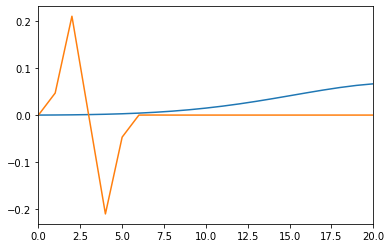

In [22]:
mu_g = 10*mu
sigma_g = 10*sigma
kgts = Kg(tt)
plt.plot(kgts)
plt.plot(k1ts)
plt.xlim([0,20])

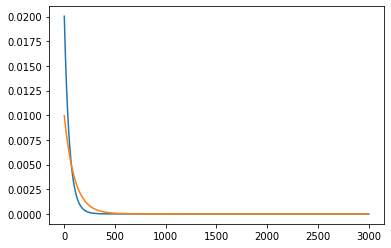

In [23]:
#plt.plot(k1ts)
plt.plot(k2ts)
plt.plot(k3ts)

In [24]:
#with feedback
r = r1.copy()
V_dark = 0.1
V = r + V_dark
theta11 =   0.0
theta10 =   -0.0
theta30 = -23.5
theta31 = -23.5
theta20 = 0.0
theta21 = 0.0

c1a = np.convolve(r,k1ts,'valid')
c2a = np.convolve(V,k2ts,'valid')
c3a = np.convolve(V,k3ts,'valid')
theta11a = 0.0005
theta10a = 0.0005

theta20a = np.mean(c2a)
theta21a = np.mean(c2a)

theta30a = np.mean(c3a)
theta31a = np.mean(c3a)

b11a = theta((c1a-theta11a))
b21a = theta((c2a-theta21a))
b31a = theta((c3a-theta31a))

b10a = theta(-(c1a+theta11a))
b20a = theta(-(c2a-theta20a))
b30a = theta(-(c3a-theta30a))

In [25]:
#without feedback
r = r2.copy()
V_dark = 0
V = r + V_dark
theta11 =   0
theta10 =   0
theta30 = -23.5
theta31 = -23.5


c1b = np.convolve(r,k1ts,'valid')
c2b = np.convolve(V,k2ts,'valid')
c3b = np.convolve(V,k3ts,'valid')

theta11b = 0.0005
theta10b = 0.0

theta20b = np.mean(c2b)
theta21b = np.mean(c2b)

theta30b = np.mean(c3b)
theta31b = np.mean(c3b)

b11b = theta((c1b-theta11b))
b21b = theta((c2b-theta21b))
b31b = theta((c3b-theta31b))

b10b = theta(-(c1b+theta10b))
b20b = theta(-(c2b-theta20b))
b30b = theta(-(c3b-theta30b))

# Input to bipolar cells (Figure 7E)

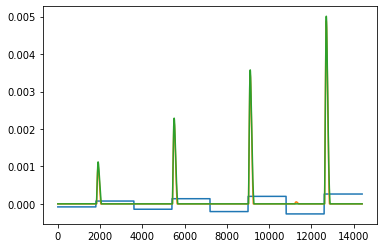

In [26]:
plt.plot((s[klen-1:]-np.mean(s))/8000)
plt.plot(b11a)
plt.plot(b11b)

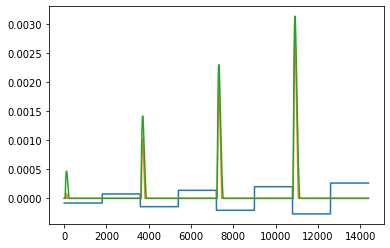

In [27]:
plt.plot((s[klen-1:]-np.mean(s))/8000)
plt.plot(b10a)
plt.plot(b10b)


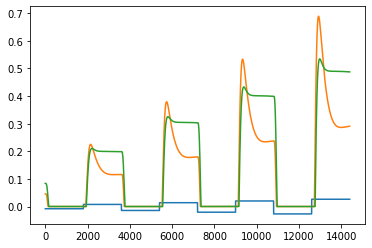

In [28]:
plt.plot((s[klen-1:]-np.mean(s))/80)
plt.plot(b21a)
plt.plot(b21b)

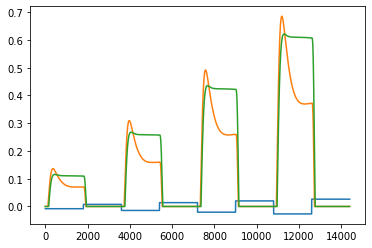

In [29]:
plt.plot((s[klen-1:]-np.mean(s))/80)
plt.plot(b20a)
plt.plot(b20b)
#plt.plot(c2b)

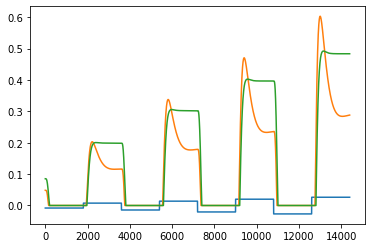

In [30]:
plt.plot((s[klen-1:]-np.mean(s))/80)
plt.plot(b31a)
plt.plot(b31b)

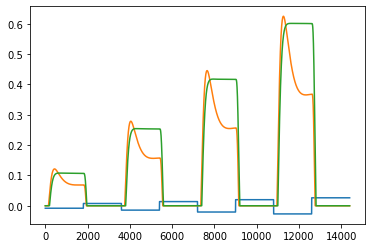

In [31]:
plt.plot((s[klen-1:]-np.mean(s))/80)
plt.plot(b30a)
plt.plot(b30b)

# Ganglion output (Figure 7F)

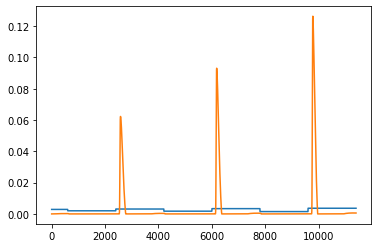

In [32]:
# case i
w1_2on=1
alpha_g1 = 1
theta_g1 = 0.0
I_g1 = w1_2on*b21a 
convolveI1 = np.convolve(I_g1,kgts,'valid')
R_g1 = theta((1-alpha_g1)*I_g1[klen-1:] + alpha_g1*convolveI1-theta_g1)
#plt.plot(I_g1[klen-1:])
plt.plot(s[2*klen-2:]/2000)
plt.plot(R_g1)
#plt.plot(alpha_g1*convolveI1)




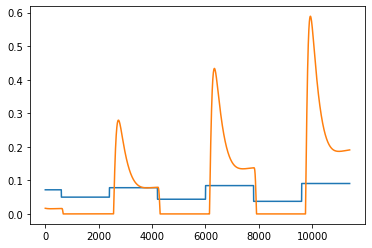

In [33]:
#case ii
w2_2on = 1
alpha_g2 =0
theta_g2 = 0.1
I_g2 = w2_2on*b21a 
convolveI2 = np.convolve(I_g2,kgts,'valid')
R_g2 = theta((1-alpha_g2)*I_g2[klen-1:] + alpha_g2*convolveI2-theta_g2)
plt.plot(s[2*klen-2:]/80)
plt.plot(R_g2)

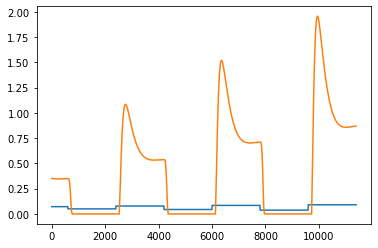

In [34]:
#case iii
w3_2on = 2
w3_3on = 1
alpha_g3 =0
theta_g3 = 0
I_g3 = w3_2on*b21a + w3_3on*b31a 
convolveI3 = np.convolve(I_g3,kgts,'valid')
R_g3 = theta((1-alpha_g3)*I_g3[klen-1:] + alpha_g3*convolveI3-theta_g3)
plt.plot(s[2*klen-2:]/80)
plt.plot(R_g3)

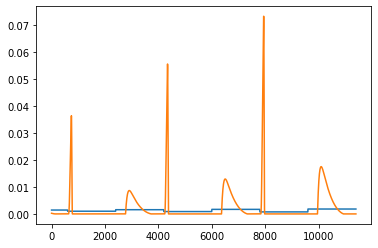

In [35]:
# case iv and v
w4_1off = 3
w4_2on = -1
alpha_g4 = 1
theta_g4 = 0
I_g4 = w4_1off*b10a + w4_2on*b21a
convolveI4 = np.convolve(I_g4,kgts,'valid')
R_g4 = theta((1-alpha_g4)*I_g4[klen-1:] + alpha_g4*convolveI4-theta_g4)
plt.plot(s[2*klen-2:]/4000)
plt.plot(R_g4)


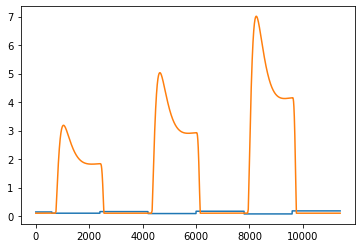

In [36]:
#case vi
w6_2off=1
w6_3off=10
alpha_g6=0
theta_g6=-0.1
I_g6 = w6_2off*b20a + w6_3off*b30a 
convolveI6 = np.convolve(I_g6,kgts,'valid')
R_g6 = theta((1-alpha_g6)*I_g6[klen-1:] + alpha_g6*convolveI6-theta_g6)
plt.plot(s[2*klen-2:]/40)
plt.plot(R_g6)

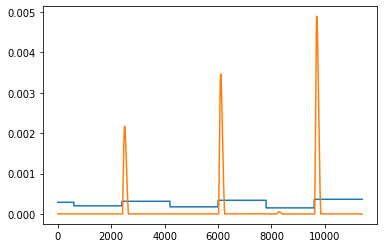

In [37]:
#case vii
w7_2on=1
alpha_g7=0
theta_g7= 0
I_g7 = w7_2on*b11a  
convolveI7 = np.convolve(I_g7,kgts,'valid')
R_g7 = theta((1-alpha_g7)*I_g7[klen-1:] + alpha_g7*convolveI7-theta_g7)
plt.plot(s[2*klen-2:]/20000)
plt.plot(R_g7)